In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
import pandas as pd

In [2]:
train_labels_df = pd.read_csv("edaicwoz/train_split.csv")
test_labels_df = pd.read_csv("edaicwoz/test_split.csv")
val_labels_df = pd.read_csv("edaicwoz/dev_split.csv")

In [3]:
def load_audio_files(data_dir, sr=16000):
    file_ids = os.listdir(data_dir)
    subject_ids = []
    file_paths = []
    types = []
    labels = []
    labels_binary = []

    for file_id in file_ids:
        file_id = file_id.split("_")[0]
        file_path = [data_dir + "/" + file_id + "/" + file_id + "_MFCC_" + str(i) + ".npy" for i in range(len(next(iter(enumerate(os.walk(data_dir + "/" + str(file_id) + "/"))))[1][2]))]
        if int(file_id) in train_labels_df["Participant_ID"].values:
            types.append(0)
            labels.append(train_labels_df[train_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(train_labels_df[train_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])
            
        elif int(file_id) in test_labels_df["Participant_ID"].values:
            types.append(1)
            labels.append(test_labels_df[test_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(test_labels_df[test_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])
        else:
            types.append(2)
            labels.append(val_labels_df[val_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(val_labels_df[val_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])
        subject_ids.append(int(file_id))
        file_paths.append(file_path)

    return file_ids, subject_ids, file_paths, types, labels, labels_binary

data_dir = "MFCCs_1030"

file_ids, subject_ids, file_paths, types, labels, labels_binary = load_audio_files(data_dir)

In [4]:
def prepare_audio_set(file_paths):

    samples = []
    samples_ids = []
    samples_types = []
    samples_labels = []
    samples_labels_binary = []

    for i, file_path in enumerate(file_paths):
        all_mfccs = []
        for j in range(len(file_path)):
            all_mfccs.append(np.load(file_path[j]))
        all_mfccs = np.array(all_mfccs)
        samples.extend(all_mfccs)
        samples_ids.extend([subject_ids[i]] * len(all_mfccs))
        samples_types.extend([types[i]] * len(all_mfccs))
        samples_labels.extend([labels[i]] * len(all_mfccs))
        samples_labels_binary.extend([labels_binary[i]] * len(all_mfccs))

    samples = np.array(samples)

    samples_ids = np.array(samples_ids)
    samples_types = np.array(samples_types)
    samples_labels = np.array(samples_labels)
    samples_labels_binary = np.array(samples_labels_binary)

    return samples, samples_ids, samples_types, samples_labels, samples_labels_binary

print("[INFO] preparing data...")
samples, samples_ids, samples_types, samples_labels, samples_labels_binary = prepare_audio_set(file_paths)
samples = np.swapaxes(samples, 1, 2)

[INFO] preparing data...


In [5]:
training_samples = samples[samples_types == 0]
training_labels = samples_labels_binary[samples_types == 0]
training_subject_ids = samples_ids[samples_types == 0]

test_samples = samples[samples_types == 1]
test_labels = samples_labels_binary[samples_types == 1]

val_samples = samples[samples_types == 2]
val_labels_df = samples_labels_binary[samples_types == 2]

In [55]:
training_samples.shape

(2350, 15001, 13)

In [7]:
import numpy as np

class DataGeneratorVanilla(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size=256):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.indices = np.arange(self.x.shape[0])

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[inds]
        batch_y = self.y[inds]
        return batch_x, batch_y
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

print("[INFO] constructing training/testing split...")
train_gen = DataGeneratorVanilla(training_samples, training_labels, 32)
test_gen = DataGeneratorVanilla(test_samples, test_labels, 32)
val_gen = DataGeneratorVanilla(val_samples, val_labels_df, 32)

[INFO] constructing training/testing split...


In [8]:
(training_samples.shape[0], training_samples.shape[1], training_samples.shape[2])

(2350, 15001, 13)

In [9]:
def create_cnn_model(input_shape):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.GRU(units = 64, input_shape = input_shape)) # , return_sequences=True
    # model.add(tf.keras.layers.GRU(units = 32))

    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

# Create the model
model = create_cnn_model((training_samples.shape[1], training_samples.shape[2]))

# Compile the model
print("[INFO] compiling model...")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

# Display the model summary
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("[INFO] fitting model...")
history = model.fit(train_gen, epochs=100, validation_data=val_gen, callbacks=[early_stopping]) # , class_weight={0: .25, 1:1}

[INFO] compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                15168     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________
[INFO] fitting model...
Epoch 1/100
74/74 [==============================] - 64s 840ms/step - loss: 0.7574 - accuracy: 0.4885 - val_loss: 0.7047 - val_accurac

In [11]:
file_ids = os.listdir("MFCCs_1030/")
val_label_file = pd.read_csv("edaicwoz/dev_split.csv")

for file_id in file_ids:
    if int(file_id) in val_label_file["Participant_ID"].values:
        all_mfccs = []
        for j in range(10):
            file_path = "MFCCs_1030/" + file_id + "/" + file_id + "_MFCC_" + str(j) + ".npy"
            all_mfccs.append(np.load(file_path))
        all_mfccs = np.array(all_mfccs)
        all_mfccs = np.swapaxes(all_mfccs, 1, 2)
        prediction = model.predict(all_mfccs, verbose=0, batch_size=8)
        prediction = prediction.mean(axis=0)
        true_label = val_label_file[val_label_file["Participant_ID"] == int(file_id)]["PHQ_Binary"].item()
        print(f'{prediction[0]:.2f} {int(prediction[0] > 0.5)}--> {true_label}')

0.27 0--> 0
0.47 0--> 0
0.46 0--> 0
0.33 0--> 0
0.38 0--> 0
0.49 0--> 1
0.31 0--> 0
0.42 0--> 0
0.37 0--> 0
0.47 0--> 0
0.43 0--> 0
0.45 0--> 1
0.53 1--> 1
0.52 1--> 1
0.45 0--> 0
0.30 0--> 0
0.34 0--> 0
0.55 1--> 1
0.40 0--> 0
0.60 1--> 1
0.55 1--> 0
0.45 0--> 0
0.54 1--> 1
0.61 1--> 0
0.55 1--> 1
0.31 0--> 0
0.45 0--> 0
0.60 1--> 0
0.55 1--> 0
0.49 0--> 0
0.41 0--> 0
0.56 1--> 0
0.59 1--> 1
0.35 0--> 0
0.55 1--> 1
0.15 0--> 0
0.66 1--> 0
0.46 0--> 0
0.44 0--> 0
0.34 0--> 0
0.56 1--> 0
0.16 0--> 0
0.63 1--> 0
0.40 0--> 0
0.46 0--> 0
0.30 0--> 0
0.43 0--> 1
0.45 0--> 0
0.33 0--> 0
0.49 0--> 0
0.55 1--> 0
0.26 0--> 0
0.43 0--> 0
0.48 0--> 0
0.52 1--> 1
0.42 0--> 0


In [12]:
from tqdm import tqdm

val_preds = []

file_ids = os.listdir("edaicwoz/merge")
val_label_file = pd.read_csv("edaicwoz/dev_split.csv")

for file_id in tqdm(file_ids):
    if int(file_id) in val_label_file["Participant_ID"].values:
        all_mfccs = []
        for j in range(10):
            file_path = "MFCCs_1030/" + file_id + "/" + file_id + "_MFCC_" + str(j) + ".npy"
            all_mfccs.append(np.load(file_path))
        all_mfccs = np.array(all_mfccs)
        all_mfccs = np.swapaxes(all_mfccs, 1, 2)
        prediction = model.predict(all_mfccs, verbose=0, batch_size=8)
        prediction = prediction.mean(axis=0)
        val_preds.append(prediction)

  0%|          | 0/275 [00:00<?, ?it/s]

100%|██████████| 275/275 [00:34<00:00,  7.92it/s]


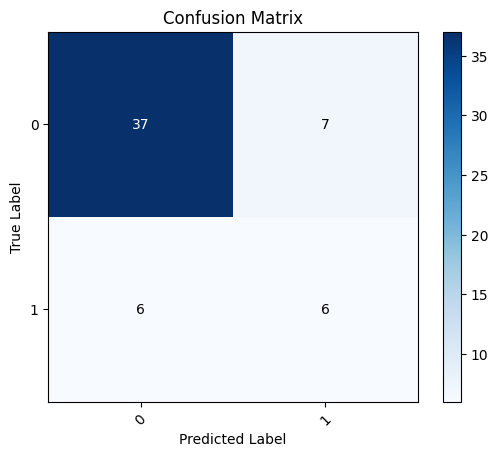

Precision: 0.46
Recall: 0.50
F1-score: 0.48
[[37  7]
 [ 6  6]]


56

In [18]:
file_i = 5

label_file = val_label_file
true = label_file.to_numpy()[:, 2].flatten().tolist()
predicted = (np.array(val_preds) > 0.5).astype(np.int32).flatten().tolist()



true_labels = true
predicted_labels = predicted

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def create_confusion_matrix(true_labels, predicted_labels):
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)
    return cm

def plot_confusion_matrix(conf_matrix, classes):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def calculate_metrics(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return precision, recall, f1

conf_matrix = create_confusion_matrix(true_labels, predicted_labels)
classes = ['0', '1']

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, classes)

# Calculate precision, recall, and F1-score
precision, recall, f1 = calculate_metrics(true_labels, predicted_labels)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
len(predicted_labels)

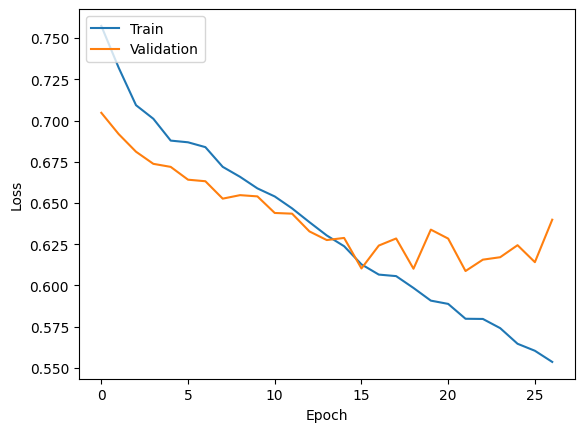

In [58]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_training_history(history)